In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import log_loss, f1_score, roc_curve, auc
import xgboost as xgb
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_csv(features_path, labels_path):
    X = pd.read_csv(features_path, index_col=0)
    y = pd.read_csv(labels_path, index_col=0)
    return X, y

In [3]:
np.random.seed(0)
X, y = load_csv('data/train_features.csv', 'data/train_targets_scored.csv')
g_cols = [col for col in X.columns if col.startswith("g-")]
c_cols = [col for col in X.columns if col.startswith("c-")]
c_idx = [X.columns.get_loc(c) for c in c_cols]

# Label encoder
X['cp_type'] = X['cp_type'].map({'ctl_vehicle': 0, 'trt_cp': 1})
X['cp_dose'] = X['cp_dose'].map({'D1': 1, 'D2': 2})

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# PCA
pca = PCA(n_components=5)
X_train_c_pca = pca.fit_transform(X_train.iloc[:, c_idx])
X_train = np.concatenate((X_train.drop(c_cols, axis=1, inplace=False).to_numpy(), X_train_c_pca), axis=1)
X_test_c_pca = pca.transform(X_test.iloc[:, c_idx])
X_test = np.concatenate((X_test.drop(c_cols, axis=1, inplace=False).to_numpy(), X_test_c_pca), axis=1)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [4]:
print(X_train[:, 0].sum())
print(X_train.shape)
print(X_test[:, 0].sum())
print(X_test.shape)

16467.0
(17860, 780)
5481.0
(5954, 780)


In [5]:
# params = {'objective':'binary:logistic', 
# #           'n_estimators': 2, 
#           'random_state': 0,
#           'eval_metric': 'logloss',
#           'verbosity': 1}

params = {'objective':'binary:logistic', # must-haves
          'random_state': 0,
          'eval_metric': 'logloss',
          'verbosity': 1,
          # high-impact hyperparameters
          'eta': 0.05, # Typical final values to be used: 0.01-0.2
          'max_depth': 10, # Typical values: 3-10
          'min_child_weight': 35,
          # other tunable hyperparameters
          'gamma': 4,
          'n_estimators': 200, 
          'colsample_bytree': 0.6, # Typical values: 0.5-1
#           'max_delta_step': 2,
          }
model = MultiOutputClassifier(xgb.XGBClassifier(**params))
clf = Pipeline([('classify', model)])
print(clf)

Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=0.6,
                                                               eta=0.05,
                                                               eval_metric='logloss',
                                                               gamma=4,
                                                               gpu_id=None,
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                                                               learni

In [6]:
clf.fit(X_train, y_train)

Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=0.6,
                                                               eta=0.05,
                                                               eval_metric='logloss',
                                                               gamma=4,
                                                               gpu_id=None,
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                                                               learni

In [7]:
y_hat = clf.predict_proba(X_test)
predictions = np.array(y_hat)[:, :, 1].T
y_pred = predictions.copy()
y_pred[X_test[:, 0] == 0] = 0
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

print(f'Predictions: {predictions.shape}')
print(f'Labels: {y_test.shape}')
print(f'Log loss (raw): {log_loss(y_test, predictions)}')
print(f'Log loss (adjusted): {log_loss(y_test[X_test[:, 0] == 1], predictions[X_test[:, 0] == 1], normalize=False) / y_test.shape[0]}')
print(f'# of positive predictions: {len(predictions[np.where(predictions > 0.5)])} / {predictions.size}')
print(f'F1: {f1_score(y_test.flatten(), y_pred.flatten())}')

Predictions: (5954, 206)
Labels: (5954, 206)
Log loss (raw): 2.661533723882192
Log loss (adjusted): 2.6615337149424962
# of positive predictions: 834 / 1226524
F1: 0.3118831425187525


In [13]:
from sklearn import metrics

def get_prec_recall_f1(pred):
    thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
    for val in thresholds:
        predictions=pred.copy()
        predictions[predictions>=val]=1
        predictions[predictions<val]=0
        # print(predictions)
        correct = 0
        wrong = 0
        f1 = 0 # 2 * (precision * recall) / (precision + recall)
        precision = 0 # tp / (tp + fp)
        recall = 0 # tp / (tp + fn)
        tp_fp = []
        for i in range(len(predictions)):
            tp_fp.append(sum(predictions[i]))
            f1 += metrics.f1_score(y_test[i], predictions[i], average = 'binary')
            precision += metrics.precision_score(y_test[i], predictions[i], average = 'binary')
            recall += metrics.recall_score(y_test[i], predictions[i], average = 'binary')

        f1 /= len(predictions)
        precision /= len(predictions)
        recall /= len(predictions)
        average_pos_predicted = sum(tp_fp) / len(predictions)
        print("Positive predictions by row")
        # print(tp_fp)
        print("Micro-average quality numbers")
        print("Threshold: {} Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, Average positive predicted: {:.4f}".format(val, precision, recall, f1, average_pos_predicted))
get_prec_recall_f1(predictions)

/Users/chloe/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chloe/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/chloe/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Positive predictions by row
Micro-average quality numbers
Threshold: 0.01 Precision: 0.0475, Recall: 0.2876, F1-measure: 0.0770, Average positive predicted: 9.6876
Positive predictions by row
Micro-average quality numbers
Threshold: 0.02 Precision: 0.0891, Recall: 0.1969, F1-measure: 0.1133, Average positive predicted: 3.2014
Positive predictions by row
Micro-average quality numbers
Threshold: 0.03 Precision: 0.1058, Recall: 0.1586, F1-measure: 0.1196, Average positive predicted: 1.4033
Positive predictions by row
Micro-average quality numbers
Threshold: 0.04 Precision: 0.1133, Recall: 0.1428, F1-measure: 0.1210, Average positive predicted: 0.8050
Positive predictions by row
Micro-average quality numbers
Threshold: 0.05 Precision: 0.1155, Recall: 0.1355, F1-measure: 0.1204, Average positive predicted: 0.5499
Positive predictions by row
Micro-average quality numbers
Threshold: 0.06 Precision: 0.1171, Recall: 0.1310, F1-measure: 0.1202, Average positive predicted: 0.4375


In [8]:
# Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test.flatten(), predictions.flatten())
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

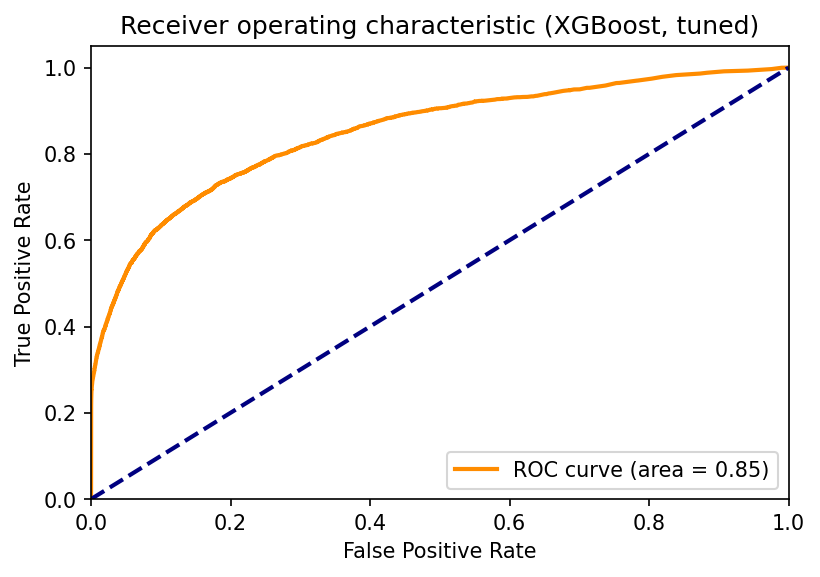

In [10]:
plt.figure(dpi=150)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (XGBoost, tuned)')
plt.legend(loc="lower right")
plt.savefig('roc_xgb_tuned.png', dpi=150)

In [17]:
y_hat = clf.predict_proba(X_test)
predictions = np.array(y_hat)[:, :, 1].T
y_pred = predictions.copy()
y_pred[X_test[:, 0] == 0] = 0
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

print(f'Predictions: {predictions.shape}')
print(f'Labels: {y_test.shape}')
print(f'Log loss (raw): {log_loss(y_test, predictions)}')
print(f'Log loss (adjusted): {log_loss(y_test[X_test[:, 0] == 1], predictions[X_test[:, 0] == 1], normalize=False) / y_test.shape[0]}')
print(f'# of positive predictions: {len(predictions[np.where(predictions > 0.5)])} / {predictions.size}')
print(f'F1: {f1_score(y_test.flatten(), y_pred.flatten())}')

Predictions: (5954, 206)
Labels: (5954, 206)
Log loss (raw): 2.748606659825106
Log loss (adjusted): 2.748606656342579
# of positive predictions: 919 / 1226524
F1: 0.33469229275868767


In [28]:
# Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test.flatten(), predictions.flatten())
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

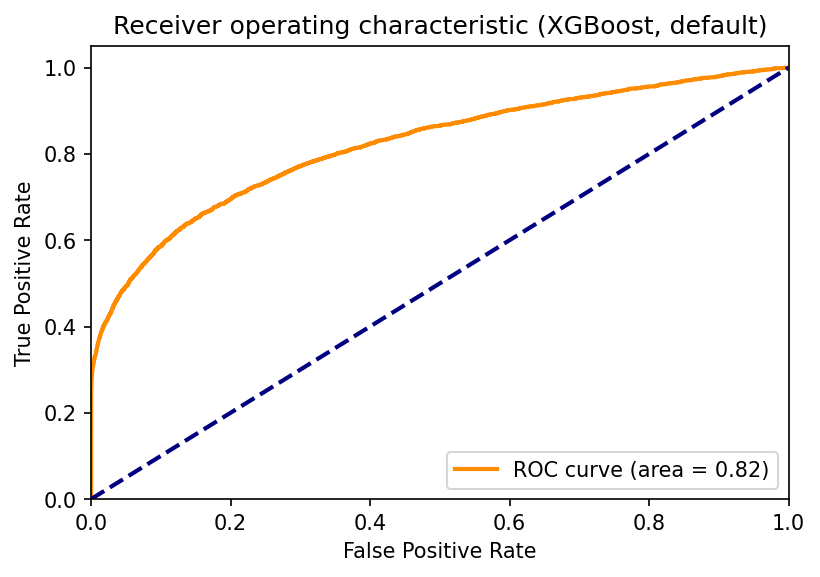

In [32]:
plt.figure(dpi=150)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (XGBoost, default)')
plt.legend(loc="lower right")
plt.savefig('roc_xgb_default.png', dpi=150)

In [7]:
y_hat = clf.predict_proba(X_test)
predictions = np.array(y_hat)[:, :, 1].T
print(f'Predictions: {predictions.shape}')
print(f'Labels: {y_test.shape}')
print(f'Log loss (raw): {log_loss(y_test, predictions)}')
print(f'Log loss (adjusted): {log_loss(y_test[X_test[:, 0] == 1], predictions[X_test[:, 0] == 1], normalize=False) / y_test.shape[0]}')
print(f'# of positive predictions: {len(predictions[np.where(predictions > 0.5)])} / {predictions.size}')
print(f'F1: f1_score(y_train.flatten(), predictions.flatten())')

Predictions: (5954, 206)
Labels: (5954, 206)
Log loss (raw): 2.748606659825106
Log loss (adjusted): 2.748606656342579
# of positive predictions: 919 / 1226524


In [7]:
y_hat = clf.predict_proba(X_test)
predictions = np.array(y_hat)[:, :, 1].T
print(f'Predictions: {predictions.shape}')
print(f'Labels: {y_test.shape}')
print(f'Log loss (raw): {log_loss(y_test, predictions)}')
print(f'Log loss (adjusted): {log_loss(y_test[X_test[:, 0] == 1], predictions[X_test[:, 0] == 1], normalize=False) / y_test.shape[0]}')
print(f'# of positive predictions: {len(predictions[np.where(predictions > 0.5)])} / {predictions.size}')

Predictions: (5954, 206)
Labels: (5954, 206)
Log loss (raw): 3.64627833713971
Log loss (adjusted): 3.6462781370827364
# of positive predictions: 877 / 1226524


In [16]:
# random seed 2020
y_hat = clf.predict_proba(X_test)
predictions = np.array(y_hat)[:, :, 1].T
print(f'Predictions: {predictions.shape}')
print(f'Labels: {y_test.shape}')
print(f'Log loss (raw): {log_loss(y_test, predictions)}')
print(f'Log loss (adjusted): {log_loss(y_test[X_test[:, 0] == 1], predictions[X_test[:, 0] == 1], normalize=False) / y_test.shape[0]}')
print(f'# of positive predictions: {len(predictions[np.where(predictions > 0.5)])} / {predictions.size}')

Predictions: (5954, 206)
Labels: (5954, 206)
Log loss (raw): 3.6463898706644384
Log loss (adjusted): 3.6463898222118885
# of positive predictions: 1225720 / 1226524


In [8]:
def get_log_loss(predictions, true_labels):
    N, M = predictions.shape # N is number of sig_ids, M is number of classes
    res = 0
    for m in range(M):
        sum_sigids = 0
        clipped = np.clip(predictions[:, m], 1e-15, 0.999)
    for i in range(N):
        sum_sigids += true_labels[i][m] * np.log(clipped[i]) + (1 - true_labels[i][m]) * np.log(1 - clipped[i])
    sum_sigids /= N
    res += sum_sigids
    # res += metrics.log_loss(true_labels[:, m], clipped, labels=[0,1])
    # print(res)
    res = - res / M
    print(res)
    return res

In [9]:
get_log_loss(predictions, y_test)

7.927616584388292e-05


7.927616584388292e-05

## Logloss
- n_estimators = 2
    - Original: 3.641420941165441
    - Only train on treatment samples: 3.928871252985628
    - Original with PCA: 3.6462781370827364
- n_estimators = 100
    - Original with PCA: 2.748606656342579

In [26]:
log_loss(y_test, predictions)

3.641420941165441

In [34]:
X, y = load_csv('data/train_features.csv', 'data/train_targets_scored.csv')
y = y[X['cp_type'] == 'trt_cp']
X = X[X['cp_type'] == 'trt_cp'].iloc[:, 1:]
X['cp_dose'] = X['cp_dose'].map({'D1': 1, 'D2': 2})
X = X.to_numpy()
y = y.to_numpy()
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y)

(21948, 874)
(21948, 206)


In [35]:
params = {'objective':'binary:logistic', 
          'n_estimators':2, 
          'random_state': 0,
          'eval_metric': 'logloss',
          'verbosity': 1}
model = MultiOutputClassifier(xgb.XGBClassifier(**params))
clf = Pipeline([('classify', model)])
print(clf)

Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               eval_metric='logloss',
                                                               gamma=None,
                                                               gpu_id=None,
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                       

In [36]:
clf.fit(X_train, y_train)

Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               eval_metric='logloss',
                                                               gamma=None,
                                                               gpu_id=None,
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                       

In [37]:
y_hat = clf.predict_proba(X_test)

In [38]:
predictions = np.array(y_hat)[:, :, 1].T
log_loss(y_test, predictions)

3.928871252985628

In [43]:
len(predictions[np.where(predictions < 0.5)])

1129459

In [45]:
predictions.size

1130322

## Hyperparameter tuning
**PARAMETERS WITH HIGH TUNABLE VALUE** (greatest impact on goal metric)
- eta [0, 1]
- max_depth [0, ∞)
- num_boost_round [1, ∞)
- min_child_weight [1, ∞)
- lambda (-∞, ∞)
- alpha (-∞, ∞)

**OTHER PARAMETERS**
- gamma [0, ∞)
- max_delta_step [0, ∞)
- subsample [0, 1]
- col_sample_bytree [0, 1]
- col_sample_bylevel [0, 1]
- n_estimators: The number of trees in the Random Forest depends on the number of rows in the data set.

In [ ]:
params = {'objective':'binary:logistic', 
          'warm_start': True,
          'n_estimators': 150,
          'random_state': 0,
          'eval_metric': 'logloss',
          'verbosity': 1}
model = MultiOutputClassifier(xgb.XGBClassifier(**params))
clf = Pipeline([('classify', model)])
print(clf)

In [10]:
params = {'min_child_weight': 1,
          'objective':'binary:logistic',
          'random_state': 0,
          'eval_metric': 'logloss',
          'verbosity': 1,
          'scale_pos_weight': 1,  # because of high class imbalance
}
grid_params = {'xgb__estimator__eta': [0.01, 0.1, 0.2],
               'xgb__estimator__max_depth': [4, 6, 10],
#                'xgb__estimator__gamma': [0, 0.05, 0.1, 0.3],
#                'xgb__estimator__max_delta_step': [0, 0.5, 1, 2], 
#                'xgb__estimator__colsample_bytree': [0.5, 0.7, 0.9, 1],
#                'xgb__estimator__subsample': [0.5, 0.7, 0.9],
               'xgb__estimator__n_estimators': range(100, 400, 100)
               }
model = MultiOutputClassifier(xgb.XGBClassifier(**params))
xgb_pipeline = Pipeline([('xgb', model)])
clf = GridSearchCV(xgb_pipeline, grid_params)
print(clf)

GridSearchCV(estimator=Pipeline(steps=[('xgb',
                                        MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                                                      booster=None,
                                                                                      colsample_bylevel=None,
                                                                                      colsample_bynode=None,
                                                                                      colsample_bytree=None,
                                                                                      eval_metric='logloss',
                                                                                      gamma=None,
                                                                                      gpu_id=None,
                                                                                      importance_type='gain',
      

In [12]:
clf.fit(X_train, y_train)

In [ ]:
params = {'objective':'binary:logistic', # must-haves
          'random_state': 0,
          'eval_metric': 'logloss',
          'verbosity': 1,
          # high-impact hyperparameters
          'eta': 0.05, # Typical final values to be used: 0.01-0.2
          'max_depth': 10, # Typical values: 3-10
          'min_child_weight': 35,
          # other tunable hyperparameters
          'gamma': 4,
          'n_estimators': 200, 
          'colsample_bytree': 0.6, # Typical values: 0.5-1
#           'max_delta_step': 2,
          }